# 04 — Attribute Visualization

This notebook visualizes the cleaned attribute metadata generated in `03_attributes.ipynb`:

- Age distribution  
- Gender counts  
- Ethnicity counts  
- Confidence histogram  
- Multi-feature plots (gender × age, ethnicity × age)

Data source:
```
data/processed/metadata/attributes_clean.parquet
```


In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned attribute data
df = pl.read_parquet("../data/processed/metadata/attributes_clean.parquet").to_pandas()

df.head()


,filename,age,gender,ethnicity,face_count,confidence
0,SFHQ_pt4_00000072.jpg,81.0,female,Asian,1,0.532229
1,SFHQ_pt4_00000090.jpg,46.0,female,Asian,1,0.526885
2,SFHQ_pt4_00000095.jpg,30.0,female,Asian,1,0.814608
3,SFHQ_pt4_00000182.jpg,34.0,female,Asian,1,0.696127
4,SFHQ_pt4_00000208.jpg,50.0,female,Asian,1,0.555390


## Age Distribution

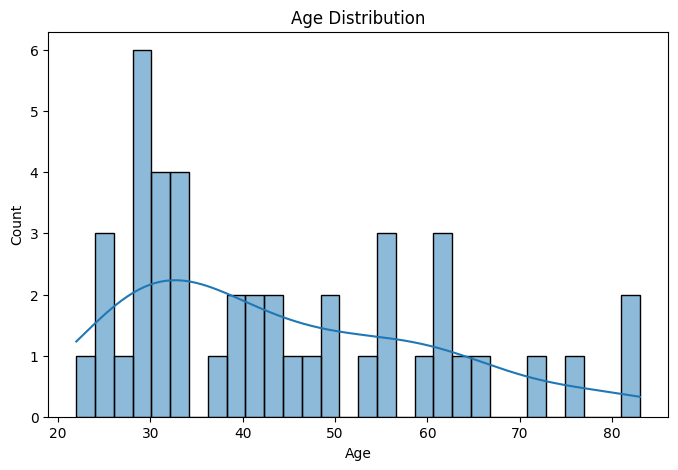

In [2]:
plt.figure(figsize=(8,5))
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

## Ethnicity Distribution

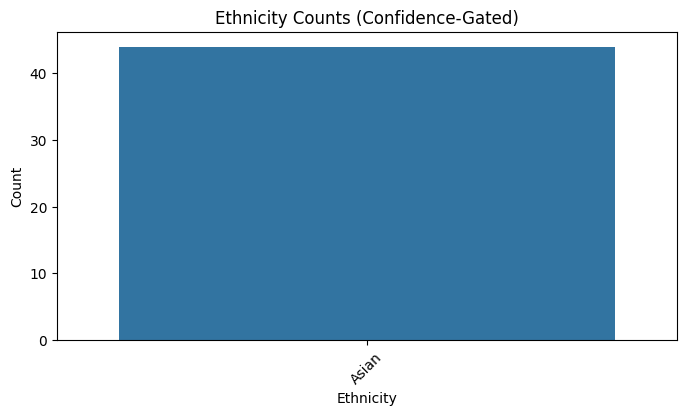

In [3]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="ethnicity", order=sorted(df["ethnicity"].unique()))
plt.title("Ethnicity Counts (Confidence-Gated)")
plt.xlabel("Ethnicity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


## Confidence Scores

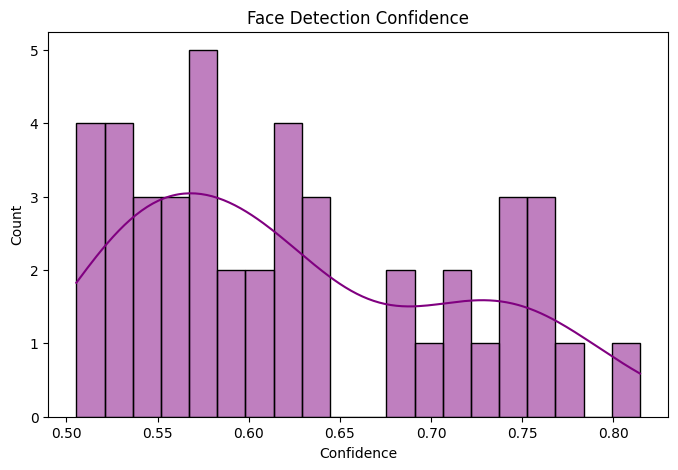

In [4]:
plt.figure(figsize=(8,5))
sns.histplot(df["confidence"], bins=20, kde=True, color="purple")
plt.title("Face Detection Confidence")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.show()


## Number of Faces Detected per Image

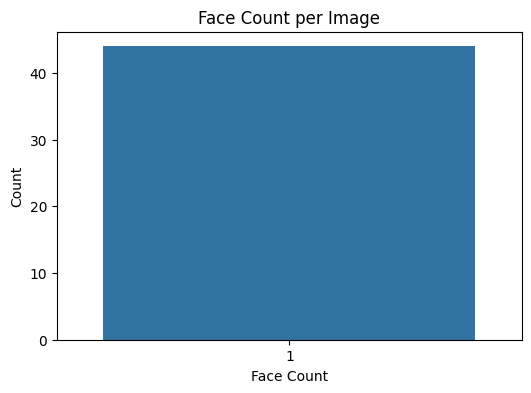

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="face_count")
plt.title("Face Count per Image")
plt.xlabel("Face Count")
plt.ylabel("Count")
plt.show()


## Age vs Gender


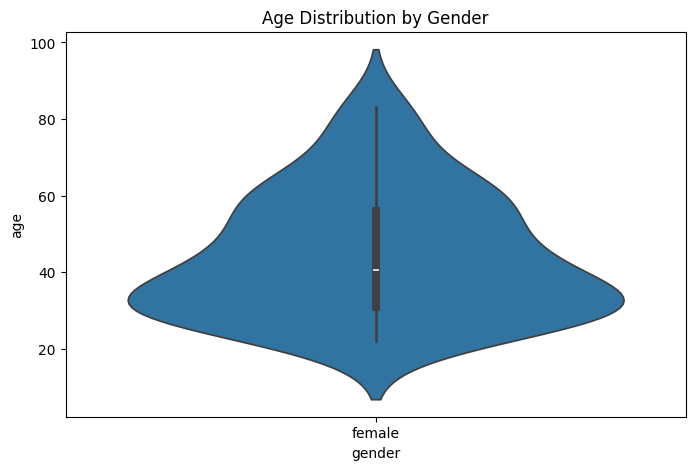

In [6]:
plt.figure(figsize=(8,5))
sns.violinplot(data=df, x="gender", y="age")
plt.title("Age Distribution by Gender")
plt.show()


## Age vs Ethnicity

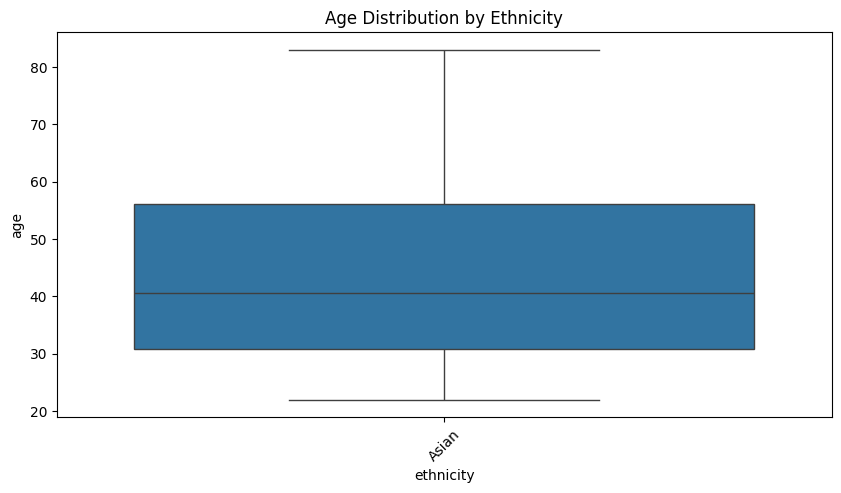

In [7]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="ethnicity", y="age")
plt.title("Age Distribution by Ethnicity")
plt.xticks(rotation=45)
plt.show()


## Filtering Outliers

In [8]:
df_filt = df[(df["age"] >= 10) & (df["age"] <= 80)]
df_filt.describe()


,age,face_count,confidence
count,42.000000,42.0,42.000000
mean,42.476190,1.0,0.628511
std,14.252493,0.0,0.087132
min,22.000000,1.0,0.505435
25%,30.250000,1.0,0.559173
50%,40.000000,1.0,0.612609
75%,54.500000,1.0,0.705580
max,75.000000,1.0,0.814608
